# Weak supervision - Pombourg dataset

This notebook will be dedicated to the classification of `(x, y, z)` points within the `Pombourg` dataset through the weak supervision framework. As a prerequisite, the geometric features must be extracted for the point cloud as well as for every class sample with the following commands:

```sh
geo3d featurize -d data -i Pombourg.las -c r g b -t 500 -n 50 200 1500
geo3d featurize --label-scene -d data -i Pombourg_vegetation.las -c r g b -t 500 -n 50 200 1500
geo3d featurize --label-scene -d data -i Pombourg_falaise.las -c r g b -t 500 -n 50 200 1500
geo3d featurize --label-scene -d data -i Pombourg_eboulis.las -c r g b -t 500 -n 50 200 1500
```

As a reminder, the `Pombourg` dataset is composed of vegetation at the top, a large cliff at the middle of the scene, and some screes at the bottom; it looks as follows:
<img src="../docs/images/pombourg.png" width="250px">

The weak supervision is a method that aims at predicting labels when annotation is scarce. It was developed by Stanford researchers, relies on the definition of *labelling functions* set by expert knowledge and on the definition of predictive neural networks, and can be summarized as follows:
<img src="../docs/images/schema-snorkel.png" width="600px">

In order to test every labelling function, it is preferable to have at least a minimal labelled dataset as input. That's why we will extract the features from the labelled samples.

## Imports

In [1]:
%matplotlib inline

In [2]:
from functools import partial
from pathlib import Path

In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [5]:
from snorkel.analysis import metric_score
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling import LabelModel
from snorkel.utils import preds_to_probs

In [6]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
import tensorflow as tf

Using TensorFlow backend.


In [7]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
from geo3dfeatures.io import read_las, load_features
from geo3dfeatures.extract import compute_tree, request_tree, extract
from geo3dfeatures.features import max_normalize, sum_normalize
from geo3dfeatures.classification import colorize_labels, save_labels
from geo3dfeatures.tools import GLOSSARY

## Global parameter setting

In [9]:
plt.style.use("seaborn-notebook")

In [10]:
DISPLAY_ALL_TEXT = False
pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

In [11]:
PREFIX_NAME = "Pombourg"
SCENE_FILE = PREFIX_NAME + ".las"
EBOULIS_FILE = PREFIX_NAME + "_eboulis.las"
VEGETATION_FILE = PREFIX_NAME + "_vegetation.las"
FALAISE_FILE = PREFIX_NAME + "_falaise.las"
DATADIR = Path("../data")

In [12]:
NEIGHBORHOOD_SIZES = [50, 200, 1500]

In [13]:
VEGETATION = 0
FALAISE = 1
EBOULIS = 2
UNKNOWN = -1
LABELS = {"eboulis": EBOULIS,
          "falaise": FALAISE,
          "vegetation": VEGETATION}

In [14]:
# Labels des coordonnées
COORDS = list("xyz")
# Labels du channel RGB (couleurs)
COULEURS = list("rgb")

## Data loading

### Raw point cloud

In [15]:
rawdata = read_las(DATADIR / "input" / SCENE_FILE)
rawdata = pd.DataFrame(rawdata, columns=list("xyzrgb"))

In [16]:
print("dimension: ", rawdata.shape)
rawdata.head()

dimension:  (672193, 6)


,x,y,z,r,g,b
0,1.977540e+06,5.242311e+06,902.684203,128.0,88.0,75.0
1,1.977540e+06,5.242311e+06,902.674986,117.0,78.0,66.0
2,1.977540e+06,5.242311e+06,902.731627,111.0,73.0,62.0
3,1.977538e+06,5.242330e+06,893.093306,147.0,135.0,131.0
4,1.977538e+06,5.242330e+06,893.049910,149.0,137.0,133.0


### Geometric features for the whole point cloud

The data is loaded for three different neighborhood sizes (50, 200, 1500). We further consider this dataset as the *testing* dataset.

In [17]:
features = load_features(DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES)

[12:29:39] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features.h5
[12:29:39] utils._init_num_threads (INFO) - NumExpr defaulting to 4 threads.


In [18]:
print("Feature dimension: ", features.shape)
features.head()

Feature dimension:  (672193, 63)


,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,planarity_1500,scattering_1500,omnivariance_1500,anisotropy_1500,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500
0,1.977525e+06,5.242324e+06,891.317748,0.334604,0.664243,2.330945,0.292404,0.085410,0.980209,0.312858,...,0.349891,0.001678,0.061972,0.998322,0.582007,1122.339474,2.042213,114.635222,917.769528,0.274770
1,1.977525e+06,5.242324e+06,891.319029,0.345110,0.653892,2.306052,0.279770,0.082896,1.012296,0.315099,...,0.360852,0.001681,0.062153,0.998319,0.588088,1113.190733,2.001808,119.309563,913.282079,0.279151
2,1.977525e+06,5.242324e+06,891.354063,0.305694,0.692340,2.284155,0.298752,0.088161,1.041689,0.308114,...,0.354059,0.001692,0.062200,0.998308,0.584418,1117.264330,1.995458,120.070114,911.133084,0.280125
3,1.977525e+06,5.242324e+06,891.390135,0.295625,0.702156,2.256683,0.312424,0.092636,1.080197,0.304651,...,0.356062,0.001723,0.062601,0.998277,0.585683,1114.302199,1.969498,123.256208,904.931612,0.285944
4,1.977525e+06,5.242324e+06,891.310728,0.335228,0.663748,2.287059,0.271698,0.080073,1.037726,0.316415,...,0.361747,0.001637,0.061615,0.998363,0.588348,1113.519679,2.010107,118.326412,918.530668,0.275069


### Geometric features for the class samples

Parallely, we compute the geometric features for every class samples, by considering the whole scene for the kd-tree querying. A set of three neighborhood sizes is used in this way. We consider this composed dataset as the *training* dataset (labels are known by definition).

In [19]:
dfveg = load_features(DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES, "vegetation")
dffalaise = load_features(DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES, "falaise")
dfeboulis = load_features(DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES, "eboulis")

[12:30:24] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features_vegetation.h5
[12:30:24] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features_falaise.h5
[12:30:24] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features_eboulis.h5


Each sample dataset is associated with its corresponding label:

In [20]:
dfeboulis["label"] = LABELS["eboulis"]
dffalaise["label"] = LABELS["falaise"]
dfveg["label"] = LABELS["vegetation"]

Then we can concatenate all the sample datasets in one single dataframe.

In [21]:
datasets = pd.concat([dfeboulis, dffalaise, dfveg], axis=0)

In [22]:
print("Dataset shape: ", datasets.shape)
datasets.head()

Dataset shape:  (73651, 64)


,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,scattering_1500,omnivariance_1500,anisotropy_1500,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500,label
0,1.977537e+06,5.242329e+06,893.466154,0.102856,0.888538,1.302015,0.376617,0.105810,5.624278,0.868071,...,0.048439,0.182927,0.951561,0.790406,933.068215,1.133958,371.814129,521.100299,0.092416,2
1,1.977537e+06,5.242329e+06,893.412794,0.114306,0.877906,1.304379,0.397675,0.110456,5.593758,0.925616,...,0.043961,0.177248,0.956039,0.783676,943.017294,1.147080,363.356412,518.349456,0.077285,2
2,1.977537e+06,5.242329e+06,893.350233,0.069191,0.921435,1.308555,0.400131,0.109770,5.540366,0.973620,...,0.039202,0.170937,0.960798,0.776052,953.072758,1.147944,362.809773,517.876294,0.062526,2
3,1.977537e+06,5.242329e+06,893.513106,0.086685,0.903080,1.304417,0.364487,0.106054,5.593269,0.817127,...,0.051292,0.186419,0.948708,0.794486,929.007483,1.142140,366.506293,531.257561,0.103562,2
4,1.977537e+06,5.242329e+06,893.286024,0.041353,0.950119,1.309976,0.415848,0.113795,5.522358,0.970630,...,0.034028,0.163037,0.965972,0.767715,963.596787,1.146678,363.611172,511.831757,0.050390,2


### Data shuffling and cleaning-up

The training dataframe is shuffled so as to remove spatial location patterns:

In [23]:
datasets = datasets.sample(frac=1.)

In [24]:
datasets.columns

Index(['x', 'y', 'z', 'alpha_50', 'beta_50', 'radius_50', 'z_range_50',
       'std_dev_50', 'density_50', 'verticality_50', 'curvature_change_50',
       'linearity_50', 'planarity_50', 'scattering_50', 'omnivariance_50',
       'anisotropy_50', 'eigenentropy_50', 'eigenvalue_sum_50', 'radius_2D_50',
       'density_2D_50', 'eigenvalue_sum_2D_50', 'eigenvalue_ratio_2D_50', 'r',
       'g', 'b', 'alpha_200', 'beta_200', 'radius_200', 'z_range_200',
       'std_dev_200', 'density_200', 'verticality_200', 'curvature_change_200',
       'linearity_200', 'planarity_200', 'scattering_200', 'omnivariance_200',
       'anisotropy_200', 'eigenentropy_200', 'eigenvalue_sum_200',
       'radius_2D_200', 'density_2D_200', 'eigenvalue_sum_2D_200',
       'eigenvalue_ratio_2D_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'std_dev_1500', 'density_1500', 'verticality_1500',
       'curvature_change_1500', 'linearity_1500', 'planarity_1500',
       'scattering_1500', 'omnivari

As we aim at applying supervised learning algorithms that may be impacted by colinearity between features, we must drop a few columns from the initial dataset. To have an insight of which column to remove based on colinearities, please consider the [notebook dedicated to the Pombourg point cloud](./features-study/pombourg-features-study.ipynb).

In [25]:
def complete_with_voisin(name, neighbors):
    """Complete the feature name with the neighborhood size as a suffix
    
    Parameters
    ----------
    name : str
        Feature name
    neighbors : list of int
        Considered neighborhood sizes
    Returns
    -------
    list of str
        Suffixed names
    """
    return [name + "_{}".format(x) for x in neighbors]

In [26]:
drop_cols = ["eigenvalue_sum_2D", "radius_2D", "std_dev", "density_2D",
             "scattering", "omnivariance", "curvature_change"]
full_cols_to_drop = sum((complete_with_voisin(x, NEIGHBORHOOD_SIZES) for x in drop_cols), [])
full_cols_to_drop

['eigenvalue_sum_2D_50',
 'eigenvalue_sum_2D_200',
 'eigenvalue_sum_2D_1500',
 'radius_2D_50',
 'radius_2D_200',
 'radius_2D_1500',
 'std_dev_50',
 'std_dev_200',
 'std_dev_1500',
 'density_2D_50',
 'density_2D_200',
 'density_2D_1500',
 'scattering_50',
 'scattering_200',
 'scattering_1500',
 'omnivariance_50',
 'omnivariance_200',
 'omnivariance_1500',
 'curvature_change_50',
 'curvature_change_200',
 'curvature_change_1500']

In [27]:
clean_dataset = (datasets
                 .drop(columns=full_cols_to_drop)
                 .drop(columns=["x", "y", "z"]))

In [28]:
print("Clean dataset shape: ", clean_dataset.shape)
clean_dataset.head()

Clean dataset shape:  (73651, 40)


,alpha_50,beta_50,radius_50,z_range_50,density_50,verticality_50,linearity_50,planarity_50,anisotropy_50,eigenentropy_50,...,z_range_1500,density_1500,verticality_1500,linearity_1500,planarity_1500,anisotropy_1500,eigenentropy_1500,eigenvalue_sum_1500,eigenvalue_ratio_2D_1500,label
8413,0.039921,0.863489,2.311263,0.396606,1.005464,0.232347,0.079229,0.856870,0.936100,0.812304,...,3.068085,29.042444,0.032066,0.585890,0.291056,0.876946,0.835168,2620.597040,0.405130,0
1652,0.066566,0.932688,1.218509,0.331116,6.861644,0.577117,0.124852,0.874681,0.999534,0.693070,...,1.866516,198.195958,0.542213,0.006769,0.992332,0.999101,0.696754,828.766765,0.211712,1
15780,0.070607,0.928803,1.177274,0.290314,7.608210,0.522274,0.131926,0.867707,0.999633,0.692388,...,1.743866,219.760223,0.508914,0.003774,0.995859,0.999633,0.694784,774.727888,0.242191,1
21759,0.100730,0.889182,1.022782,0.075836,11.602860,0.009329,0.183584,0.810287,0.993871,0.708226,...,1.045441,335.144145,0.134960,0.184923,0.680362,0.865285,0.891700,591.770997,0.676442,2
21618,0.034713,0.801927,1.003580,0.152222,12.281702,0.122211,0.070824,0.818076,0.888900,0.866190,...,0.865112,354.752250,0.110806,0.150621,0.770551,0.921172,0.832361,511.383270,0.691745,2


We apply to the data a minimal normalization scheme, by only modifying density features.

In [29]:
for size in NEIGHBORHOOD_SIZES:
    k = str(size)
    clean_dataset["density_" + k] = preprocessing.minmax_scale(clean_dataset["density_" + k])

## Implement a weak supervision model

The following section is inspired from a [Snorkel tutorial](https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb).

### Dataset splitting

First we will split the dataset in train, dev, valid and test subsets:
- the **training set** will be used for labelling function calibration, as well as for discrimative model;
- the **dev set** is a small dataset that will validate the labelling function relevance;
- the **validation set** is useful for validate the generative model learning process, based on labelling function outputs. It is used in the discriminant model as well in a monitoring perspective;
- the **test set** is used in the final discriminant model.

The splitting scheme is setup as follows:
- 80% for training+dev, 20% for validation+test
- dev is 10% of the training+dev block
- test is 25% of the validation+test block

In [30]:
VALID_TEST_PART = 0.2
DEV_PART_IN_TRAINING = 0.1
idx_split = int(clean_dataset.shape[0] * VALID_TEST_PART)

In [31]:
df_train = clean_dataset.iloc[:-idx_split]
df_dev = df_train.sample(int(DEV_PART_IN_TRAINING * df_train.shape[0]))
df_valid_test = clean_dataset.iloc[-idx_split:]
df_valid, df_test = train_test_split(df_valid_test, random_state=123, stratify=df_valid_test.label)

In [32]:
print("train: ", df_train.shape)
print("dev: ", df_dev.shape)
print("valid: ", df_valid.shape)
print("test: ", df_test.shape)

train:  (58921, 40)
dev:  (5892, 40)
valid:  (11047, 40)
test:  (3683, 40)


As a verification, one can see if the labels are balanced in the chosen split:

In [33]:
df_train.groupby("label")["label"].count()

label
0    13482
1    25978
2    19461
Name: label, dtype: int64

In [34]:
df_dev.groupby("label")["label"].count()

label
0    1295
1    2636
2    1961
Name: label, dtype: int64

We pull out the label vectors for ease of use later:

In [35]:
Y_dev = df_dev.label.values
Y_valid = df_valid.label.values
Y_test = df_test.label.values

### Labelling functions definition

#### Utility functions

In order to make the labelling function definition clearer, one defines a bunch of utility functions in order to apply treatments on groups of features, for each neighborhood size.

In [36]:
def mean_features(df, name, size=NEIGHBORHOOD_SIZES):
    cols = [name + "_" + str(num) for num in size]
    return df[cols].mean()

In [37]:
def diff_voisin_features(df, name, size=NEIGHBORHOOD_SIZES):
    cols = [name + "_" + str(num) for num in size]
    return df[cols[-1]] - df[cols[0]]

In [38]:
def max_value_features(df, name, size=NEIGHBORHOOD_SIZES):
    cols = [name + "_" + str(num) for num in size]
    return df[cols].max()

In [39]:
def gamma(df, size=NEIGHBORHOOD_SIZES):
    return pd.Series({("gamma_" + str(num)): 1 - (df["alpha_" + str(num)] + df["beta_" + str(num)]) for num in size})

#### Labelling functions

The verticality is a key concept there, one can discriminate features starting from the verticality coefficient value: if larger than 0.5, one certainly gets a cliff point.

In [40]:
@labeling_function()
def verticality(x):
    coeff = mean_features(x, "verticality")
    beta_value = diff_voisin_features(x, "beta")
    if coeff >= 0.5:
        return FALAISE
    if beta_value <= 0.:
        return VEGETATION
    return EBOULIS

As an alternative definition of verticality, one can consider the `e2/e1` ratio, in the 2D case (`(x, y)`). When the value is small, the local neighborhood is linear with respect to the 2D projection (*e.g.* the projection of a vertical plane, like a wall, over `(x, y)` gives a line).

In [41]:
@labeling_function()
def eigenratio_2d(x):
    value = mean_features(x, "eigenvalue_ratio_2D")
    if value < 0.25:
        return FALAISE
    return UNKNOWN

If considering the normalized eigenvalue sum, the values is very small for cliffs, relatively high for vegetation, and median for screes.

In [42]:
@labeling_function()
def eigenvalue_sum(x):
    value = mean_features(x, "eigenvalue_sum")
    if value >= 0.5:
        return VEGETATION
    if value > 0.1:
        return EBOULIS
    return FALAISE

When considering the normalized density, one gets high values for screes, median values for cliffs, and small values for vegetation.

In [43]:
@labeling_function()
def density_3D(x):
    value = max_value_features(x, "density")
    if value < 0.2:
        return VEGETATION
    if value <= 0.5:
        return FALAISE
    return EBOULIS

Afterward, one considers the `gamma` coefficient (*i.e.* the third barycentric coordinate, see [geometric feature notebooks](http://localhost:8888/notebooks/examples/features-study/escale-features-study.ipynb)). It is high for vegetation (3D environment), and very low for cliffs (2D environments).

In [44]:
@labeling_function()
def increasing_gamma(x):
    df_gamma = gamma(x)
    value = diff_voisin_features(df_gamma, "gamma")
    if value >= 0.2:
        return VEGETATION
    if mean_features(df_gamma, "gamma") <= 0.01:
        return FALAISE
    return EBOULIS    

Then one considers the planarity variable; which is quite small for the vegetation, reasonably high for the cliffs.

In [45]:
@labeling_function()
def planarity(x):
    value = mean_features(x, "planarity")
    if value <= 0.6:
        return VEGETATION
    value = max_value_features(x, "planarity")
    if value > 0.9:
        return FALAISE
    return EBOULIS

As a last labelling function, one considers the `beta` variable (second barycentric coordinate), which denotes clear 2D patterns. Hence this coefficient is high for cliffs, and smaller when dealing with vegetation.

In [46]:
@labeling_function()
def beta(x):
    value = mean_features(x, "beta")
    if value <= 0.6:
        return VEGETATION
    value = max_value_features(x, "beta")
    if value > 0.9:
        return FALAISE
    return EBOULIS

The *labelling functions* set is summarized as a list:

In [47]:
lfs = [verticality, eigenvalue_sum, eigenratio_2d, density_3D, increasing_gamma, planarity, beta]

These functions are applied to *training* (around 5 minutes) et *dev* (around 30 seconds) datasets:

In [48]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)

[12:30:25] warnings._showwarnmsg (WARNING) - /home/rdelhome/.virtualenvs/univers/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel

100%|██████████| 5892/5892 [00:34<00:00, 168.57it/s]


In [49]:
L_train.shape

(58921, 7)

As an output, one gets as many rows as points, and as many columns as labelling functions. The corresponding value (for the i-th point, at the j-th labelling functions) is the sensed label, depending on the expert knowledge that one has (that's not the final output, and the "true" model prediction!).

Some statistics are available through the *Snorkel* API:
- *polarity*: all the output labels for each labelling functions;
- *coverage*: the labelling function coverage, with respect to the label set;
- *overlaps*: may equal the coverage, it represents the proportion of redundant labelling (same labels provided by other labelling functions);
- *conflicts*: the proportion of divergent labelling (between the current labelling function and any other one);
- *correct*: amount of correct prediction (confusion matrix diagonal sum);
- *incorrect*: amount of wrong prediction (with respect to the confusion matrix);
- *emp. acc.*: empirical accuracy (ratio between correct and incorrect prediction, ABSTAIN and UNKNOWN labels apart).

In [50]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
verticality,0,"[0, 1, 2]",1.000000,1.000000,0.967075
eigenvalue_sum,1,[0],1.000000,1.000000,0.967075
eigenratio_2d,2,[1],0.388181,0.388181,0.388181
density_3D,3,"[0, 1, 2]",1.000000,1.000000,0.967075
increasing_gamma,4,"[0, 1, 2]",1.000000,1.000000,0.967075
planarity,5,"[0, 1, 2]",1.000000,1.000000,0.967075
beta,6,"[0, 1, 2]",1.000000,1.000000,0.967075


In [51]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
verticality,0,"[0, 1, 2]",1.000000,1.000000,0.967074,4106,1786,0.696877
eigenvalue_sum,1,[0],1.000000,1.000000,0.967074,1295,4597,0.219790
eigenratio_2d,2,[1],0.393924,0.393924,0.393924,2162,159,0.931495
density_3D,3,"[0, 1, 2]",1.000000,1.000000,0.967074,4929,963,0.836558
increasing_gamma,4,"[0, 1, 2]",1.000000,1.000000,0.967074,4610,1282,0.782417
planarity,5,"[0, 1, 2]",1.000000,1.000000,0.967074,4108,1784,0.697217
beta,6,"[0, 1, 2]",1.000000,1.000000,0.967074,3738,2154,0.634420


In [52]:
L_valid = applier.apply(df=df_valid)

[12:36:48] warnings._showwarnmsg (WARNING) - /home/rdelhome/.virtualenvs/univers/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel

100%|██████████| 11047/11047 [01:07<00:00, 163.71it/s]


### Generative model

The generative model builds a weight matrix from a neural network in order to output label probability distributions, for each point. It is a way to denoise the signal provided by the labelling functions : while these functions may be highly correlated, the generative model outputs strong probabilistic labels from labeling function output combinations.

In [53]:
label_model = LabelModel(cardinality=len(LABELS), verbose=True)

In [54]:
label_model.fit(L_train=L_train, n_epochs=5000, lr=0.001, log_freq=100, seed=123)

[12:37:55] label_model.fit (INFO) - Computing O...
[12:37:55] label_model.fit (INFO) - Estimating \mu...
[12:37:55] logger.log (INFO) - [0 epochs]: TRAIN:[loss=9.795]
[12:37:55] logger.log (INFO) - [100 epochs]: TRAIN:[loss=0.206]
[12:37:56] logger.log (INFO) - [200 epochs]: TRAIN:[loss=0.136]
[12:37:56] logger.log (INFO) - [300 epochs]: TRAIN:[loss=0.111]
[12:37:56] logger.log (INFO) - [400 epochs]: TRAIN:[loss=0.093]
[12:37:56] logger.log (INFO) - [500 epochs]: TRAIN:[loss=0.079]
[12:37:56] logger.log (INFO) - [600 epochs]: TRAIN:[loss=0.069]
[12:37:56] logger.log (INFO) - [700 epochs]: TRAIN:[loss=0.064]
[12:37:56] logger.log (INFO) - [800 epochs]: TRAIN:[loss=0.060]
[12:37:56] logger.log (INFO) - [900 epochs]: TRAIN:[loss=0.057]
[12:37:56] logger.log (INFO) - [1000 epochs]: TRAIN:[loss=0.056]
[12:37:56] logger.log (INFO) - [1100 epochs]: TRAIN:[loss=0.054]
[12:37:56] logger.log (INFO) - [1200 epochs]: TRAIN:[loss=0.053]
[12:37:56] logger.log (INFO) - [1300 epochs]: TRAIN:[loss=0.05

The accuracy of the generative model is computed with respect to the **validation dataset**. This metric highly depends on the defined labelling functions.

In [55]:
label_model_acc = label_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

[12:37:59] label_model.score (WARNING) - Metrics calculated over data points with non-abstain labels only


Label Model Accuracy:     89.9%


By considering only samples from the `Pombourg` dataset, one gets a nice 89.3% accuracy, which is pretty good.

One may plot the probability distribution functions for each label: how the probabilities of encountering each label are distributed?

In [56]:
def plot_probabilities_histogram(Y, name):
    plt.hist(Y, bins=10)
    plt.xlabel(f"Probability of {name}")
    plt.ylabel("Number of data points")
    plt.show()

For the cliffs, the model provides clear prediction : the probabilities are either close to 0, or to 1. This meant that, given the point of interest, it is almost always confident about the fact that it is a cliff point, or not. 

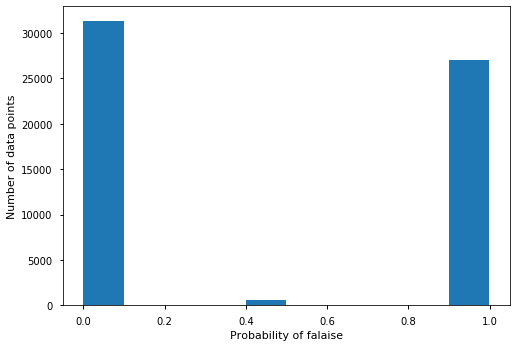

In [57]:
probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, FALAISE], "falaise")

For the vegetation and scree labels, the model prediction is clear for a large amount of points, however there are some more balanced situations as well...

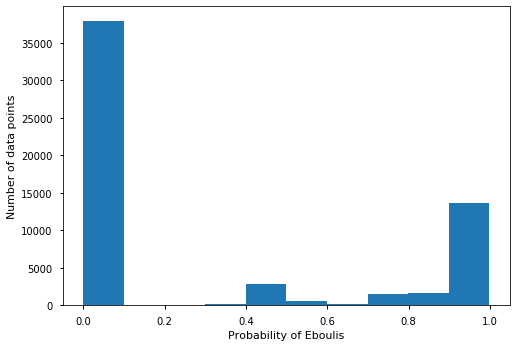

In [58]:
plot_probabilities_histogram(probs_train[:, EBOULIS], "Eboulis")

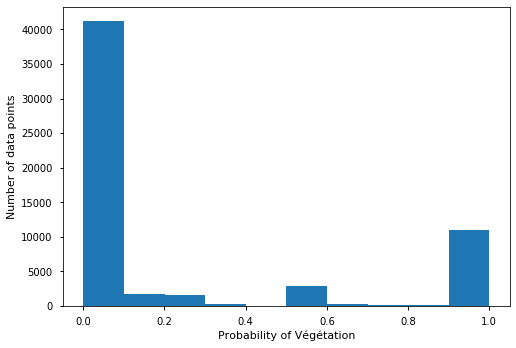

In [59]:
plot_probabilities_histogram(probs_train[:, VEGETATION], "Végétation")

If there is still unclassified points after this step, one may filter them through the *Snorkel* API (it is not the case in our example).

In [60]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [61]:
df_train.shape, df_train_filtered.shape, probs_train_filtered.shape

((58921, 40), (58921, 40), (58921, 3))

### Discriminative model

As a final step of the framework, one may train a predictive model based on the generative model outputs. The probabilities are denoised and free from correlation schemes. Hence one can generalize the prediction to unknown points.

In [64]:
X_train = df_train.drop(columns=["label"])
X_dev = df_dev.drop(columns=["label"])
X_valid = df_valid.drop(columns=["label"])
X_test = df_test.drop(columns=["label"])

Our predictive model will be a neural network built with the Keras API. One uses the Adam optimizer, and monitors the model accuracy.

In [65]:
def baseline_model(input_dim):
    # Create model
    model = tf.keras.Sequential()
    activation_name = "relu"
    model.add(tf.keras.layers.Dense(16, activation=activation_name, input_shape=(input_dim,)))
    model.add(tf.keras.layers.Dense(16, activation=activation_name))
    model.add(tf.keras.layers.Dense(8, activation=activation_name))
    model.add(
        tf.keras.layers.Dense(
            units=3, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='softmax'
        )
    )
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [66]:
kmodel = KerasClassifier(
    build_fn=partial(baseline_model, input_dim=X_train.shape[1]),
    epochs=20,
    validation_data=(preprocessing.scale(X_valid), preds_to_probs(Y_valid, 3)),
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, verbose=1, restore_best_weights=True
    )],
    verbose=1
)

The model is fitted with the training set.

In [67]:
kmodel.fit(x=preprocessing.scale(X_train), y=probs_train)

Train on 58921 samples, validate on 11047 samples
Epoch 1/20
58921/58921 [==============================] - 5s 80us/sample - loss: 0.2981 - accuracy: 0.9197 - val_loss: 0.3683 - val_accuracy: 0.8876
Epoch 2/20
58921/58921 [==============================] - 3s 53us/sample - loss: 0.1918 - accuracy: 0.9482 - val_loss: 0.4458 - val_accuracy: 0.8711
Epoch 3/20
58921/58921 [==============================] - 3s 56us/sample - loss: 0.1834 - accuracy: 0.9510 - val_loss: 0.5041 - val_accuracy: 0.8648
Epoch 4/20
58921/58921 [==============================] - 2s 42us/sample - loss: 0.1777 - accuracy: 0.9541 - val_loss: 0.5201 - val_accuracy: 0.8732
Epoch 5/20
58921/58921 [==============================] - 3s 43us/sample - loss: 0.1733 - accuracy: 0.9554 - val_loss: 0.5571 - val_accuracy: 0.8765
Epoch 6/20
58921/58921 [==============================] - 3s 58us/sample - loss: 0.1703 - accuracy: 0.9563 - val_loss: 0.6047 - val_accuracy: 0.8830
Epoch 00006: early stopping


And afterwards, one predictes the testing set labels, and measures the test accuracy in order to have an idea on the model performance.

In [68]:
preds_test = kmodel.predict(preprocessing.scale(X_test))

3683/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [69]:
# preds_test = keras_model.predict(x=X_test).argmax(axis=1)
test_acc = metric_score(golds=Y_test, preds=preds_test, metric="accuracy")
print(f"Test Accuracy: {test_acc * 100:.1f}%")

Test Accuracy: 87.4%


87.4% of accuracy, that seems to be a pretty satisfying model, it is time to apply it to the whole dataset!

## Predict the whole scene

As this stage, one has a trained model with a correct test accuracy. One may apply it to the whole scene (that is composed of a much larger amount of points).

In [70]:
clean_scene = (features
               .drop(columns=full_cols_to_drop)
               .drop(columns=["x", "y", "z"]))

In [71]:
label = kmodel.predict(preprocessing.scale(clean_scene))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [72]:
pd.Series(label).groupby(label).count()

0    225934
1    220026
2    226233
dtype: int64

## Save the labelled point cloud

Now one has the output labels, one may save them as a `.las` on the disk.

In [73]:
outdf = colorize_labels(features[COORDS], label, GLOSSARY)

In [74]:
save_labels(outdf, DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES, "weaksup", "full")

[12:38:37] classification.save_labels (INFO) - Predicted labels saved into ../data/output/Pombourg/prediction/weaksup-50-200-1500-full.las


Here comes an insight of the output point cloud, this is interesting, however some job still has to be done!


Legend:
- green: vegetation
- grey: cliff
- marron: scree 

<img src="../docs/images/Pombourg_weaksup-50-200-1500.png" width="200px">